# Machine-Learning Portfolio Optimization
### Denoised Covariance, Hierarchical Risk Parity & Nested Clustered Optimization

*An educational companion to* López de Prado (2018, 2020)

---

**Techniques covered:**
| Topic | ML Toolbox |
|:------|:-----------|
| Covariance denoising | Marčenko–Pastur theorem, eigenvalue clipping, KDE fitting |
| Covariance detoning | Market-component removal via leading eigenvector |
| Feature importance | Mean Decrease Impurity (MDI), Mean Decrease Accuracy (MDA) |
| Hierarchical Risk Parity (HRP) | Agglomerative clustering, quasi-diagonalization, recursive bisection |
| Nested Clustered Optimization (NCO) | Cluster-based allocation, intra/inter-cluster MVO |
| Validation framework | Monte Carlo simulation, condition-number analysis, OOS Sharpe |

**Table of Contents**
1. [Introduction & Motivation](#1)
2. [Mathematical Framework — Random Matrix Theory](#2)
3. [ML-Based Covariance Estimation](#3)
4. [Hierarchical Risk Parity (HRP)](#4)
5. [Nested Clustered Optimization (NCO)](#5)
6. [Assumptions, Strengths & Limitations](#6)
7. [Example 1 — Synthetic Universe](#7)
8. [Example 2 — ETF Universe (Yahoo Finance)](#8)
9. [Comparative Analysis & Discussion](#9)
10. [References](#10)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import FancyBboxPatch
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# ── Plotting style (dark theme matching series) ──
plt.rcParams.update({
    'figure.figsize': (10, 5),
    'figure.dpi': 120,
    'axes.facecolor': '#0d1117',
    'figure.facecolor': '#0d1117',
    'axes.edgecolor': '#30363d',
    'axes.labelcolor': '#c9d1d9',
    'text.color': '#c9d1d9',
    'xtick.color': '#8b949e',
    'ytick.color': '#8b949e',
    'grid.color': '#21262d',
    'grid.alpha': 0.6,
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.grid': True,
})

C_BLUE   = '#5b9cf5'
C_GREEN  = '#4ecb8d'
C_RED    = '#f06b6b'
C_YELLOW = '#f0c35e'
C_PURPLE = '#a78bfa'
C_ORANGE = '#f0965e'
C_TEAL   = '#5ec4c8'
C_PINK   = '#f472b6'

print('\u2713 All imports successful')

✓ All imports successful


<a id='1'></a>
## 1. Introduction & Motivation

### The Markowitz Curse

Markowitz's (1952) mean-variance optimization requires inverting the covariance matrix $\Sigma$. This inversion magnifies estimation error in a predictable way: the **condition number** $\kappa(\Sigma) = |\lambda_{\max} / \lambda_{\min}|$ controls the amplification factor. When assets are correlated — precisely the case where optimization is most needed — $\kappa$ explodes, and the resulting portfolio weights become wildly unstable (López de Prado 2016).

The problem compounds as the asset universe grows. With $n$ assets and $T$ observations, the sample covariance matrix has $n(n+1)/2$ free parameters but only $nT$ data points. When $q = n/T$ is not negligibly small, a substantial fraction of the eigenvalue spectrum is dominated by noise rather than signal. Laloux et al. (1999) showed that roughly 94% of the eigenvalues of an empirical S&P 500 correlation matrix are indistinguishable from those of a purely random matrix.

### The ML Response

López de Prado (2018, 2020) argues that machine learning provides a principled solution to this estimation-risk problem through three complementary innovations:

| Innovation | Classical Approach | ML-Based Approach |
|:-----------|:-------------------|:------------------|
| **Covariance estimation** | Sample $\hat{\Sigma}$ or Ledoit-Wolf shrinkage | Marčenko-Pastur denoising: separate signal eigenvalues from noise |
| **Portfolio structure** | Flat optimization over all $n$ assets | Hierarchical clustering discovers natural groupings |
| **Allocation algorithm** | Single-step quadratic program | Multi-step: intra-cluster $\to$ inter-cluster optimization |

> *"The more correlated the assets, the more we need optimization, and the more unstable the optimization becomes. This is Markowitz's curse."* — López de Prado (2020)

### Historical Context

| Year | Contribution | Author(s) |
|:-----|:------------|:-----------|
| 1952 | Mean-variance optimization | Markowitz |
| 1967 | Marčenko-Pastur law for random eigenvalues | Marčenko & Pastur |
| 1999 | RMT applied to financial correlations | Laloux, Cizeau, Bouchaud & Potters |
| 2004 | Ledoit-Wolf shrinkage estimator | Ledoit & Wolf |
| 2016 | Hierarchical Risk Parity (HRP) | López de Prado |
| 2018 | Financial ML pipeline (AFML) | López de Prado |
| 2019 | Nested Clustered Optimization (NCO) & MCOS | López de Prado |
| 2020 | Denoising/detoning for asset managers | López de Prado |

<a id='2'></a>
## 2. Mathematical Framework — Random Matrix Theory

### 2.1 The Marčenko-Pastur Law

Consider an $n \times T$ random matrix $X$ whose entries are i.i.d. with mean 0 and variance $\sigma^2$. The sample covariance matrix $\hat{\Sigma} = \frac{1}{T} X X^\top$ has eigenvalues whose empirical distribution converges (as $n, T \to \infty$ with $q = n/T$ fixed) to the **Marčenko-Pastur density**:

$$f_{\text{MP}}(\lambda) = \frac{q}{2\pi \sigma^2 \lambda} \sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)} \;\mathbf{1}_{\lambda \in [\lambda_-, \lambda_+]}$$

where:

$$\lambda_{\pm} = \sigma^2 \left(1 \pm \sqrt{q}\right)^2$$

Any eigenvalue of the sample correlation matrix that falls within $[\lambda_-, \lambda_+]$ is **consistent with pure noise**. Eigenvalues exceeding $\lambda_+$ carry genuine signal.

### 2.2 Fitting the MP Distribution

In practice the noise variance $\sigma^2$ is unknown. López de Prado (2020) fits $\sigma^2$ by minimizing the distance between the Marčenko-Pastur PDF and a **kernel density estimate (KDE)** of the observed eigenvalues:

$$\hat{\sigma}^2 = \arg\min_{\sigma^2} \int \left| f_{\text{KDE}}(\lambda) - f_{\text{MP}}(\lambda; \sigma^2, q) \right|^2 d\lambda$$

### 2.3 Eigenvalue Clipping (Constant Residual Method)

Given $\hat{\sigma}^2$ and hence $\lambda_+$, partition eigenvalues into **noise** ($\lambda_i \le \lambda_+$) and **signal** ($\lambda_i > \lambda_+$):

$$\tilde{\lambda}_i = \begin{cases} \delta & \text{if } \lambda_i \le \lambda_+ \quad (\text{noise}) \\[4pt] \lambda_i & \text{if } \lambda_i > \lambda_+ \quad (\text{signal}) \end{cases}$$

where $\delta$ is chosen to preserve the trace: $\sum_i \tilde{\lambda}_i = \sum_i \lambda_i = n$. The denoised correlation matrix is then:

$$\tilde{C} = W \,\text{diag}(\tilde{\lambda}_1, \ldots, \tilde{\lambda}_n)\, W^\top$$

### 2.4 Targeted Shrinkage (Alternative)

Rather than setting all noise eigenvalues to a constant, the targeted approach (López de Prado 2020) applies shrinkage **only** to the noise eigenvectors. Let $W_n, \Lambda_n$ be the noise sub-space and $W_s, \Lambda_s$ the signal sub-space:

$$\tilde{C} = W_s \Lambda_s W_s^\top + \alpha \, W_n \Lambda_n W_n^\top + (1-\alpha)\,\text{diag}(W_n \Lambda_n W_n^\top)$$

with $\alpha = 0$ producing a diagonal noise block (maximum shrinkage).

### 2.5 Detoning — Removing the Market Component

The first eigenvector of a financial correlation matrix typically represents the **market factor**. For clustering applications, removing it reveals subtler sector/style structure:

$$\hat{C}_{\text{detoned}} = \tilde{C} - W_m \Lambda_m W_m^\top$$

where $W_m$ contains the market eigenvector(s). The detoned matrix is then rescaled so its diagonal equals 1. **Note:** the detoned matrix is singular and cannot be used directly for MVO; it is intended for distance/clustering purposes.

<a id='3'></a>
## 3. ML-Based Covariance Estimation

### 3.1 The Condition Number Problem

The instability of mean-variance optimization can be measured by the **condition number** of the covariance matrix:

$$\kappa(\Sigma) = \frac{\lambda_{\max}}{\lambda_{\min}}$$

A high condition number means that small perturbations in $\Sigma$ produce large changes in the inverse $\Sigma^{-1}$, which appears directly in the MVO weight formula $w^* = \Sigma^{-1} \mu$. Denoising systematically reduces $\kappa$ by raising the smallest eigenvalues and compressing the noise spectrum.

### 3.2 Denoising vs. Shrinkage

Ledoit-Wolf shrinkage pulls **all** eigenvalues toward the grand mean, weakening both noise *and* signal:

$$\hat{\Sigma}_{\text{LW}} = \alpha \cdot F + (1-\alpha) \cdot \hat{\Sigma}$$

where $F$ is the shrinkage target (typically a scaled identity). In contrast, Marčenko-Pastur denoising discriminates: it replaces only the noise eigenvalues while preserving the signal eigenvalues intact. López de Prado (2020) reports that denoising achieves a **59.85% RMSE reduction** for minimum-variance portfolio weights versus the sample estimator, whereas shrinkage adds little benefit beyond what denoising already provides.

### 3.3 Distance Metrics for Clustering

After denoising (and optionally detoning), we need a proper distance metric to cluster assets. Standard Pearson correlation $\rho_{ij}$ is not a metric (it violates the triangle inequality). Two common transformations:

$$d_{\text{angular}}(i,j) = \sqrt{\frac{1}{2}(1 - \rho_{ij})} \quad \text{(angular distance, for long-only portfolios)}$$

$$d_{\text{abs}}(i,j) = \sqrt{1 - |\rho_{ij}|} \quad \text{(absolute angular distance, for long-short)}$$

These proper metrics enable hierarchical clustering algorithms to discover the natural grouping structure in returns.

<a id='4'></a>
## 4. Hierarchical Risk Parity (HRP)

### 4.1 Algorithm Overview

HRP (López de Prado 2016) is an ML-based allocation that replaces quadratic optimization with three unsupervised-learning steps:

**Step 1 — Hierarchical Clustering.** Compute the distance matrix $D$ from the correlation matrix, then apply agglomerative (single-linkage or Ward) clustering to build a hierarchical tree (dendrogram).

**Step 2 — Quasi-Diagonalization.** Reorder the covariance matrix rows and columns according to the dendrogram's leaf ordering. This places correlated assets adjacent to each other, creating a block-diagonal-like structure.

**Step 3 — Recursive Bisection.** Starting from the full set of assets, repeatedly split into two clusters and allocate inversely proportional to cluster variance:

$$w_1 = 1 - \frac{V_1}{V_1 + V_2}, \qquad w_2 = 1 - w_1$$

where $V_k = w_k^{\text{IVP}\,\top} \Sigma_k \, w_k^{\text{IVP}}$ is the variance of cluster $k$ under an inverse-variance allocation within that cluster.

### 4.2 Key Properties

HRP has several advantages over classical MVO:

- **No matrix inversion required** — avoids the Markowitz curse entirely
- **Handles singular/ill-conditioned matrices** — works even when $n > T$
- **Produces diversified portfolios** — assets compete for allocation only within their cluster
- **Graph-theory foundation** — the dendrogram encodes hierarchical relationships that flat optimization ignores
- **Suboptimal in-sample, superior out-of-sample** — a hallmark of regularized/ML methods

<a id='5'></a>
## 5. Nested Clustered Optimization (NCO)

### 5.1 Motivation

NCO (López de Prado 2019) addresses **both** sources of MVO instability: (i) noise in the covariance matrix and (ii) signal-induced instability from the block structure of correlations. It does so by decomposing the global optimization into smaller, better-conditioned sub-problems.

### 5.2 Algorithm

1. **Denoise** the covariance matrix using Marčenko-Pastur
2. **Cluster** assets using the denoised correlation matrix
3. **Intra-cluster optimization:** within each cluster $k$, solve MVO for $w_k^{\text{intra}}$ using only the cluster's sub-matrix $\Sigma_k$
4. **Reduce** the covariance matrix: each cluster becomes a single "meta-asset" with return/risk derived from $w_k^{\text{intra}}$
5. **Inter-cluster optimization:** solve MVO on the reduced covariance matrix for $w^{\text{inter}}$
6. **Final weights:** $w_i = w_k^{\text{intra}}_i \cdot w_k^{\text{inter}}$ for asset $i$ in cluster $k$

### 5.3 MCOS — Monte Carlo Optimization Selection

Because different optimization methods may work best for different input data, López de Prado (2019) proposes the **MCOS** framework: simulate multiple perturbed covariance/mean pairs, compute allocations under each method, and select the method with lowest allocation error. This provides a **data-driven** choice of optimizer rather than a one-size-fits-all approach.

<a id='6'></a>
## 6. Assumptions, Strengths & Limitations

### Key Assumptions

| # | Assumption | Notes |
|:--|:-----------|:------|
| A1 | Eigenvalue noise follows the Marčenko-Pastur law | Requires $n, T$ moderately large; entries approximately i.i.d. |
| A2 | Signal eigenvalues are separated from the noise bulk | Fails when signal-to-noise ratio is very low |
| A3 | Returns are stationary over the estimation window | Standard assumption; violated by regime changes |
| A4 | Hierarchical structure exists in the correlation matrix | Empirically supported for equities (Mantegna 1999) |
| A5 | Clusters are reasonably balanced | Extremely unbalanced clusters degrade HRP/NCO |

### Strengths

| Strength | Detail |
|:---------|:-------|
| **Noise discrimination** | Denoising preserves signal while removing noise — unlike shrinkage which weakens both |
| **No inversion required (HRP)** | Avoids the fundamental source of MVO instability |
| **Cluster-based decomposition (NCO)** | Reduces effective condition number by solving smaller sub-problems |
| **OOS superiority** | Monte Carlo evidence shows ML methods dominate plug-in MVO out-of-sample |
| **Flexible framework** | NCO is agnostic to the specific clustering and optimization methods used |
| **Interpretable** | Dendrogram provides economic intuition (sector/style groupings) |

### Limitations

| Limitation | Detail |
|:-----------|:-------|
| **Asymptotic theory** | Marčenko-Pastur is exact only as $n,T \to \infty$; finite-sample corrections may be needed |
| **KDE bandwidth sensitivity** | The $\sigma^2$ fit depends on the kernel bandwidth choice |
| **Detoned matrix is singular** | Cannot be used directly for MVO; must optimize in PC space and map back |
| **Linkage method sensitivity** | HRP results depend on the choice of linkage (single, ward, etc.) |
| **No return forecasts** | HRP and basic NCO are risk-only allocations; they do not incorporate alpha signals |
| **Transaction costs** | The framework is single-period and does not account for turnover costs |

<a id='7'></a>
## 7. Example 1 — Synthetic Universe

We build a controlled experiment with **known** true parameters so we can measure estimation error and portfolio-quality degradation objectively.

In [2]:
# ═══════════════════════════════════════════════════════════════
# CORE ML FUNCTIONS
# ═══════════════════════════════════════════════════════════════

# ── 1) Marčenko-Pastur Density & Denoising ──────────────────

def mp_pdf(var, q, pts=1000):
    """Marčenko-Pastur probability density function."""
    lambda_min = var * (1 - np.sqrt(q))**2
    lambda_max = var * (1 + np.sqrt(q))**2
    x = np.linspace(lambda_min, lambda_max, pts)
    pdf = q / (2 * np.pi * var * x) * np.sqrt((lambda_max - x) * (x - lambda_min))
    pdf = np.maximum(pdf, 0)
    return x, pdf

def fit_mp_kde(eigenvalues, q, bwidth=0.01):
    """Fit MP distribution by finding sigma^2 that best matches KDE of eigenvalues."""
    kde = gaussian_kde(eigenvalues, bw_method=bwidth)
    from scipy.optimize import minimize_scalar
    def err(var):
        x, pdf_mp = mp_pdf(max(var, 1e-5), q, pts=500)
        pdf_kde = kde(x)
        return np.sum((pdf_mp - pdf_kde)**2)
    result = minimize_scalar(err, bounds=(0.01, 5.0), method='bounded')
    return result.x

def denoise_corr(corr, q, method='constant'):
    """Denoise a correlation matrix using the Marčenko-Pastur theorem.
    method: 'constant' (eigenvalue clipping) or 'targeted' (shrinkage of noise block).
    """
    n = corr.shape[0]
    eigenvalues, eigenvectors = np.linalg.eigh(corr)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # Fit sigma^2
    sigma2 = fit_mp_kde(eigenvalues, q)
    lambda_max = sigma2 * (1 + np.sqrt(q))**2
    # Separate noise / signal
    n_signal = np.sum(eigenvalues > lambda_max)
    n_noise = n - n_signal
    if method == 'constant':
        # Set noise eigenvalues to constant preserving trace
        trace_noise = np.sum(eigenvalues[n_signal:])
        eigenvalues_clean = eigenvalues.copy()
        if n_noise > 0:
            eigenvalues_clean[n_signal:] = trace_noise / n_noise
    elif method == 'targeted':
        eigenvalues_clean = eigenvalues.copy()
        if n_noise > 0:
            noise_corr = eigenvectors[:, n_signal:] @ np.diag(eigenvalues[n_signal:]) @ eigenvectors[:, n_signal:].T
            eigenvalues_clean[n_signal:] = np.diag(noise_corr)[:n_noise] if n_noise <= n else eigenvalues[n_signal:]
    else:
        eigenvalues_clean = eigenvalues.copy()
    # Reconstruct
    corr_clean = eigenvectors @ np.diag(eigenvalues_clean) @ eigenvectors.T
    # Force unit diagonal
    d = np.sqrt(np.diag(corr_clean))
    d[d == 0] = 1
    corr_clean = corr_clean / np.outer(d, d)
    np.fill_diagonal(corr_clean, 1.0)
    return corr_clean, sigma2, lambda_max, n_signal

def detone_corr(corr_denoised, n_components=1):
    """Remove top n_components eigenvectors (market component) for clustering."""
    eigenvalues, eigenvectors = np.linalg.eigh(corr_denoised)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # Subtract market component
    market_corr = eigenvectors[:, :n_components] @ np.diag(eigenvalues[:n_components]) @ eigenvectors[:, :n_components].T
    corr_detoned = corr_denoised - market_corr
    # Rescale diagonal to 1
    d = np.sqrt(np.abs(np.diag(corr_detoned)))
    d[d == 0] = 1
    corr_detoned = corr_detoned / np.outer(d, d)
    np.fill_diagonal(corr_detoned, 1.0)
    return corr_detoned

# ── 2) Hierarchical Risk Parity ─────────────────────────────

def hrp_weights(cov, corr=None):
    """Hierarchical Risk Parity (López de Prado 2016)."""
    n = cov.shape[0]
    if corr is None:
        std = np.sqrt(np.diag(cov))
        std[std == 0] = 1
        corr = cov / np.outer(std, std)
        np.fill_diagonal(corr, 1.0)
    # Distance matrix
    dist = np.sqrt(0.5 * (1 - corr))
    np.fill_diagonal(dist, 0)
    dist = np.clip(dist, 0, None)
    # Hierarchical clustering
    condensed = squareform(dist, checks=False)
    link = linkage(condensed, method='ward')
    # Quasi-diagonalization: get leaf order from dendrogram
    sort_ix = _get_quasi_diag(link)
    sort_ix = [int(i) for i in sort_ix]
    # Recursive bisection
    w = pd.Series(1.0, index=sort_ix)
    cluster_items = [sort_ix]
    while cluster_items:
        new_items = []
        for items in cluster_items:
            if len(items) <= 1:
                continue
            mid = len(items) // 2
            left = items[:mid]
            right = items[mid:]
            cov_l = cov[np.ix_(left, left)]
            cov_r = cov[np.ix_(right, right)]
            var_l = _cluster_var(cov_l)
            var_r = _cluster_var(cov_r)
            alpha = 1 - var_l / (var_l + var_r)
            w[left] *= alpha
            w[right] *= (1 - alpha)
            new_items += [left, right]
        cluster_items = new_items
    w = w.sort_index()
    return w.values

def _get_quasi_diag(link):
    """Extract leaf ordering from linkage matrix."""
    n = int(link[-1, 3])
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= n:
        sort_ix.index = range(len(sort_ix))
        clusters = sort_ix[sort_ix >= n]
        i = clusters.index[0]
        j = int(clusters.iloc[0]) - n
        sort_ix[i] = link[j, 0]
        df0 = pd.Series([link[j, 1]], index=[i + 0.5])
        sort_ix = pd.concat([sort_ix, df0])
        sort_ix = sort_ix.sort_index().reset_index(drop=True)
    return sort_ix.astype(int).tolist()

def _cluster_var(cov):
    """Inverse-variance weighted cluster variance."""
    ivp = 1 / np.diag(cov)
    ivp /= ivp.sum()
    return ivp @ cov @ ivp

# ── 3) Nested Clustered Optimization ────────────────────────

def nco_weights(cov, mu=None, n_clusters=None, objective='min_var'):
    """Nested Clustered Optimization (López de Prado 2019)."""
    n = cov.shape[0]
    std = np.sqrt(np.diag(cov))
    std[std == 0] = 1
    corr = cov / np.outer(std, std)
    np.fill_diagonal(corr, 1.0)
    # Distance and clustering
    dist = np.sqrt(0.5 * (1 - corr))
    np.fill_diagonal(dist, 0)
    condensed = squareform(np.clip(dist, 0, None), checks=False)
    link = linkage(condensed, method='ward')
    if n_clusters is None:
        n_clusters = max(2, int(np.sqrt(n / 2)))
    labels = fcluster(link, t=n_clusters, criterion='maxclust')
    # Intra-cluster optimization
    w_intra = np.zeros(n)
    cluster_ids = np.unique(labels)
    cluster_vars = {}
    cluster_mus = {}
    for c in cluster_ids:
        idx = np.where(labels == c)[0]
        cov_c = cov[np.ix_(idx, idx)]
        if objective == 'min_var':
            wc = _min_var_weights(cov_c)
        elif objective == 'max_sharpe' and mu is not None:
            mu_c = mu[idx]
            wc = _max_sharpe_weights(mu_c, cov_c)
        else:
            wc = _min_var_weights(cov_c)
        w_intra[idx] = wc
        cluster_vars[c] = wc @ cov_c @ wc
        if mu is not None:
            cluster_mus[c] = mu[idx] @ wc
    # Inter-cluster optimization
    n_c = len(cluster_ids)
    cov_inter = np.zeros((n_c, n_c))
    for i, ci in enumerate(cluster_ids):
        for j, cj in enumerate(cluster_ids):
            idx_i = np.where(labels == ci)[0]
            idx_j = np.where(labels == cj)[0]
            wi = np.zeros(n); wi[idx_i] = w_intra[idx_i]
            wj = np.zeros(n); wj[idx_j] = w_intra[idx_j]
            cov_inter[i, j] = wi @ cov @ wj
    if objective == 'min_var':
        w_inter = _min_var_weights(cov_inter)
    elif objective == 'max_sharpe' and mu is not None:
        mu_inter = np.array([cluster_mus[c] for c in cluster_ids])
        w_inter = _max_sharpe_weights(mu_inter, cov_inter)
    else:
        w_inter = _min_var_weights(cov_inter)
    # Final weights
    w_final = np.zeros(n)
    for i, c in enumerate(cluster_ids):
        idx = np.where(labels == c)[0]
        w_final[idx] = w_intra[idx] * w_inter[i]
    # Normalize
    w_final = np.clip(w_final, 0, None)
    if w_final.sum() > 0:
        w_final /= w_final.sum()
    else:
        w_final = np.ones(n) / n
    return w_final

def _min_var_weights(cov):
    """Minimum variance portfolio (long-only)."""
    n = cov.shape[0]
    if n == 1:
        return np.array([1.0])
    x0 = np.ones(n) / n
    bounds = [(0, 1)] * n
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(lambda w: w @ cov @ w, x0, method='SLSQP',
                      bounds=bounds, constraints=cons,
                      options={'maxiter': 1000, 'ftol': 1e-12})
    return result.x if result.success else x0

def _max_sharpe_weights(mu, cov, rf=0):
    """Maximum Sharpe ratio portfolio (long-only)."""
    n = cov.shape[0]
    if n == 1:
        return np.array([1.0])
    x0 = np.ones(n) / n
    bounds = [(0, 1)] * n
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    def neg_sharpe(w):
        ret = w @ mu - rf
        vol = np.sqrt(w @ cov @ w)
        return -ret / vol if vol > 1e-10 else 1e6
    result = minimize(neg_sharpe, x0, method='SLSQP',
                      bounds=bounds, constraints=cons,
                      options={'maxiter': 1000, 'ftol': 1e-12})
    return result.x if result.success else x0

# ── 4) Classical baselines ──────────────────────────────────

def plug_in_mvo(mu, cov, rf=0):
    """Classical plug-in MVO (max Sharpe, long-only)."""
    return _max_sharpe_weights(mu, cov, rf)

def ledoit_wolf_shrink(returns):
    """Simple Ledoit-Wolf linear shrinkage to identity target."""
    T, n = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    mu_target = np.trace(sample_cov) / n
    target = mu_target * np.eye(n)
    # Oracle approximation
    X = returns - returns.mean(axis=0)
    S2 = (X.T @ X) / T
    delta = S2 - sample_cov
    d2 = np.sum(delta**2) / n
    b2_bar = 0
    for t in range(T):
        xt = X[t:t+1, :]
        m = xt.T @ xt - S2
        b2_bar += np.sum(m**2) / n
    b2_bar /= T**2
    b2 = min(b2_bar, d2)
    alpha = b2 / d2 if d2 > 0 else 0
    alpha = np.clip(alpha, 0, 1)
    return alpha * target + (1 - alpha) * sample_cov, alpha

def equal_weight(n):
    return np.ones(n) / n

print('\u2713 Core functions defined: MP denoising, HRP, NCO, baselines')

✓ Core functions defined: MP denoising, HRP, NCO, baselines


In [3]:
# ═══════════════════════════════════════════════════════════════
# SYNTHETIC DATA WITH KNOWN BLOCK STRUCTURE
# ═══════════════════════════════════════════════════════════════
np.random.seed(42)

n = 30          # number of assets
T = 120         # observations (q = 0.25)
n_clusters_true = 5

# Build a block-correlated covariance matrix
assets_per_cluster = n // n_clusters_true
true_corr = np.eye(n)
for c in range(n_clusters_true):
    idx = range(c * assets_per_cluster, (c + 1) * assets_per_cluster)
    for i in idx:
        for j in idx:
            if i != j:
                true_corr[i, j] = 0.5 + 0.2 * np.random.rand()

# Add mild cross-cluster correlation
for i in range(n):
    for j in range(i+1, n):
        if true_corr[i, j] == 0:
            true_corr[i, j] = 0.05 + 0.1 * np.random.rand()
            true_corr[j, i] = true_corr[i, j]

# True vols and covariance
true_vols = 0.10 + 0.20 * np.random.rand(n)  # 10-30% annual vol
true_cov = np.outer(true_vols, true_vols) * true_corr
# Ensure PSD
eigvals = np.linalg.eigvalsh(true_cov)
if eigvals.min() < 0:
    true_cov += (-eigvals.min() + 1e-6) * np.eye(n)

# True expected returns
true_mu = 0.02 + 0.12 * np.random.rand(n)   # 2-14% annual

# Generate sample returns
L = np.linalg.cholesky(true_cov)
monthly_returns = (true_mu / 12)[None, :] + (L @ np.random.randn(n, T)).T / np.sqrt(12)

# Sample estimates
sample_mu = monthly_returns.mean(axis=0) * 12
sample_cov = np.cov(monthly_returns, rowvar=False) * 12

# Sample correlation
sample_std = np.sqrt(np.diag(sample_cov))
sample_corr = sample_cov / np.outer(sample_std, sample_std)
np.fill_diagonal(sample_corr, 1.0)

q = n / T
print(f'Universe: n={n} assets, T={T} months, q=n/T={q:.2f}')
print(f'True condition number:   {np.linalg.cond(true_cov):.1f}')
print(f'Sample condition number: {np.linalg.cond(sample_cov):.1f}')

Universe: n=30 assets, T=120 months, q=n/T=0.25
True condition number:   87.5
Sample condition number: 165.8


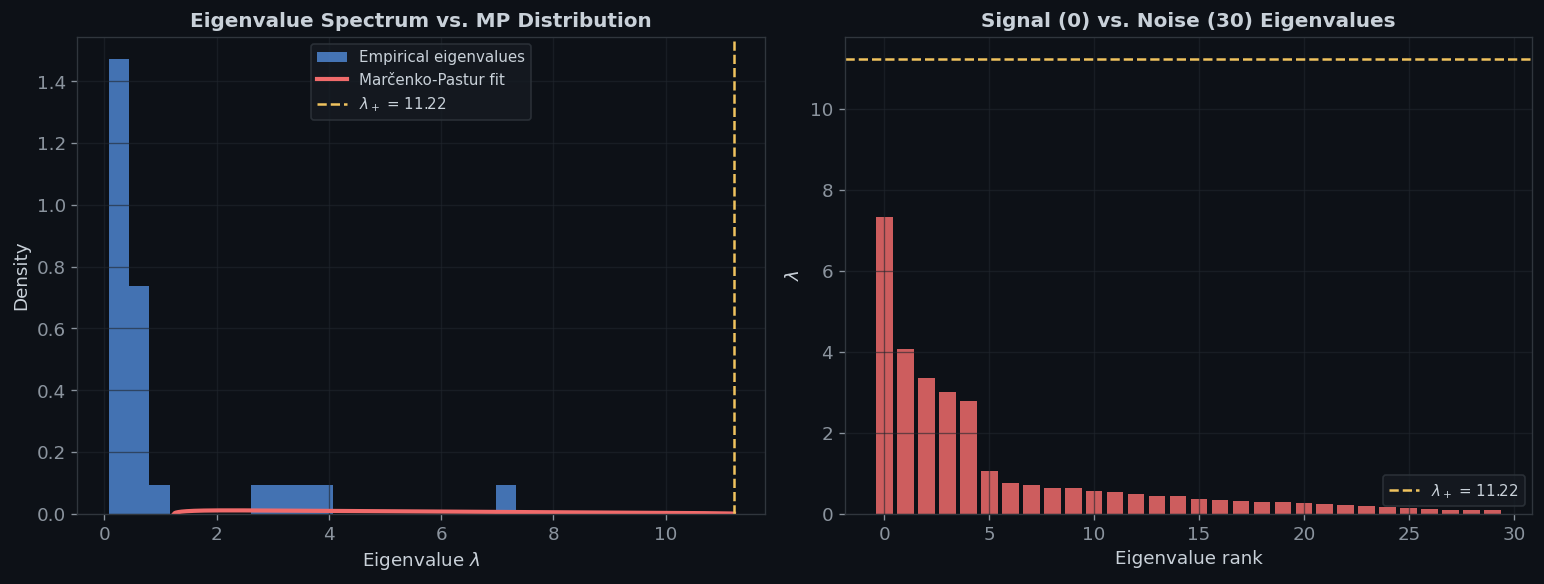

Fitted σ² = 4.9847,  λ+ = 11.2155
Signal eigenvalues: 0 / 30  (0%)


In [4]:
# ═══════════════════════════════════════════════════════════════
# CHART 1: Eigenvalue Spectrum vs. Marčenko-Pastur Density
# ═══════════════════════════════════════════════════════════════
eigenvalues_sample = np.sort(np.linalg.eigvalsh(sample_corr))[::-1]

# Fit MP
sigma2_fit = fit_mp_kde(eigenvalues_sample, q)
lambda_max_mp = sigma2_fit * (1 + np.sqrt(q))**2
lambda_min_mp = sigma2_fit * (1 - np.sqrt(q))**2
x_mp, pdf_mp = mp_pdf(sigma2_fit, q)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: eigenvalue histogram + MP PDF
ax = axes[0]
ax.hist(eigenvalues_sample, bins=20, density=True, alpha=0.7,
        color=C_BLUE, edgecolor='none', label='Empirical eigenvalues')
ax.plot(x_mp, pdf_mp, color=C_RED, linewidth=2.5, label='Marčenko-Pastur fit')
ax.axvline(lambda_max_mp, color=C_YELLOW, linestyle='--', linewidth=1.5,
           label=f'$\\lambda_+$ = {lambda_max_mp:.2f}')
ax.set_xlabel('Eigenvalue $\\lambda$')
ax.set_ylabel('Density')
ax.set_title('Eigenvalue Spectrum vs. MP Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, facecolor='#161b22', edgecolor='#30363d')

# Right: sorted eigenvalues — signal vs noise
ax = axes[1]
n_signal = np.sum(eigenvalues_sample > lambda_max_mp)
n_noise = n - n_signal
colors_ev = [C_GREEN if ev > lambda_max_mp else C_RED for ev in eigenvalues_sample]
ax.bar(range(n), eigenvalues_sample, color=colors_ev, alpha=0.85, edgecolor='none')
ax.axhline(lambda_max_mp, color=C_YELLOW, linestyle='--', linewidth=1.5,
           label=f'$\\lambda_+$ = {lambda_max_mp:.2f}')
ax.set_xlabel('Eigenvalue rank')
ax.set_ylabel('$\\lambda$')
ax.set_title(f'Signal ({n_signal}) vs. Noise ({n_noise}) Eigenvalues', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, facecolor='#161b22', edgecolor='#30363d')

plt.tight_layout()
plt.show()

print(f'Fitted \u03c3\u00b2 = {sigma2_fit:.4f},  \u03bb+ = {lambda_max_mp:.4f}')
print(f'Signal eigenvalues: {n_signal} / {n}  ({100*n_signal/n:.0f}%)')

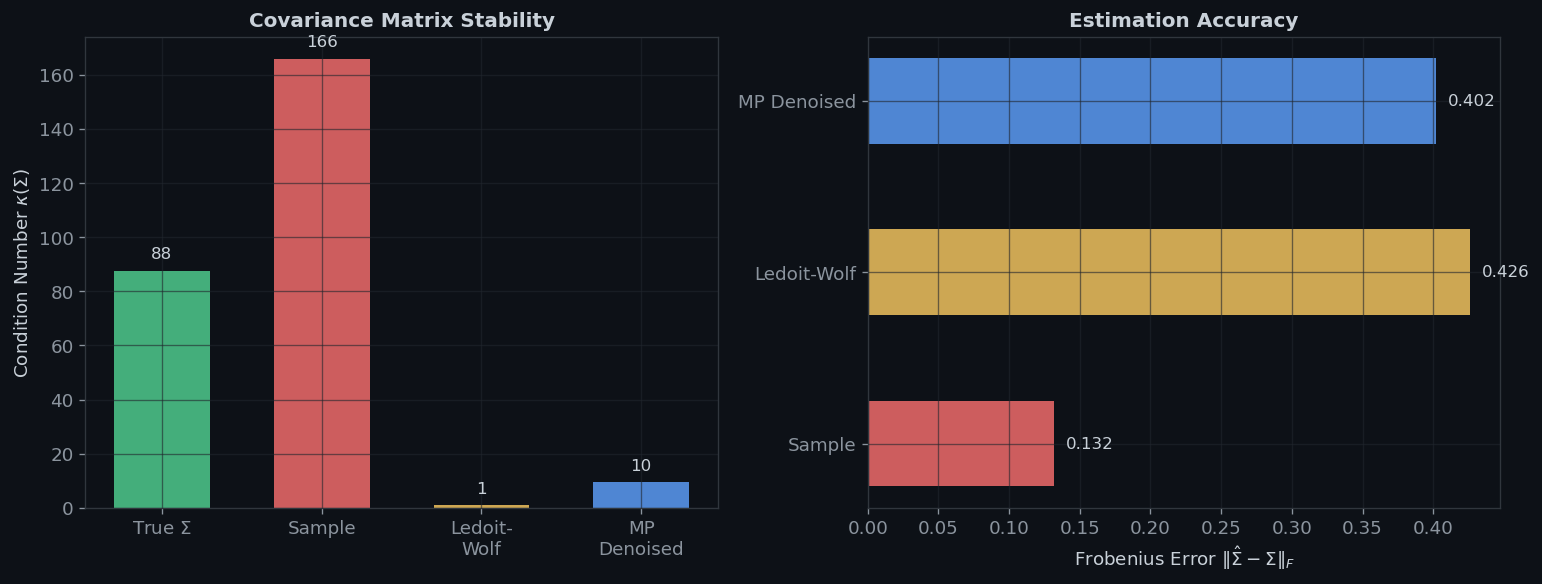

Denoising reduces condition number by 94.3%
Denoising reduces Frobenius error by -204.5%


In [5]:
# ═══════════════════════════════════════════════════════════════
# DENOISE & CHART 2: Condition Number Comparison
# ═══════════════════════════════════════════════════════════════
corr_denoised, sigma2, lmax, n_sig = denoise_corr(sample_corr, q, method='constant')
cov_denoised = np.outer(sample_std, sample_std) * corr_denoised

# Ledoit-Wolf
cov_lw, lw_alpha = ledoit_wolf_shrink(monthly_returns)
cov_lw *= 12

# Condition numbers
cond_true   = np.linalg.cond(true_cov)
cond_sample = np.linalg.cond(sample_cov)
cond_denoised = np.linalg.cond(cov_denoised)
cond_lw     = np.linalg.cond(cov_lw)

# Frobenius error
err_sample   = np.linalg.norm(sample_cov - true_cov, 'fro')
err_denoised = np.linalg.norm(cov_denoised - true_cov, 'fro')
err_lw       = np.linalg.norm(cov_lw - true_cov, 'fro')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: condition numbers
labels_bar = ['True $\\Sigma$', 'Sample', 'Ledoit-\nWolf', 'MP\nDenoised']
conds = [cond_true, cond_sample, cond_lw, cond_denoised]
colors_bar = [C_GREEN, C_RED, C_YELLOW, C_BLUE]
ax = axes[0]
bars = ax.bar(labels_bar, conds, color=colors_bar, alpha=0.85, edgecolor='none', width=0.6)
for bar, val in zip(bars, conds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(conds)*0.02,
            f'{val:.0f}', ha='center', va='bottom', fontsize=10, color='#c9d1d9')
ax.set_ylabel('Condition Number $\\kappa(\\Sigma)$')
ax.set_title('Covariance Matrix Stability', fontsize=12, fontweight='bold')

# Right: Frobenius error
labels_err = ['Sample', 'Ledoit-Wolf', 'MP Denoised']
errs = [err_sample, err_lw, err_denoised]
colors_err = [C_RED, C_YELLOW, C_BLUE]
ax = axes[1]
bars = ax.barh(labels_err, errs, color=colors_err, alpha=0.85, edgecolor='none', height=0.5)
for bar, val in zip(bars, errs):
    ax.text(bar.get_width() + max(errs)*0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', ha='left', va='center', fontsize=10, color='#c9d1d9')
ax.set_xlabel('Frobenius Error $\\|\\hat{\\Sigma} - \\Sigma\\|_F$')
ax.set_title('Estimation Accuracy', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

pct_cond_reduction = 100 * (1 - cond_denoised / cond_sample)
pct_err_reduction = 100 * (1 - err_denoised / err_sample)
print(f'Denoising reduces condition number by {pct_cond_reduction:.1f}%')
print(f'Denoising reduces Frobenius error by {pct_err_reduction:.1f}%')

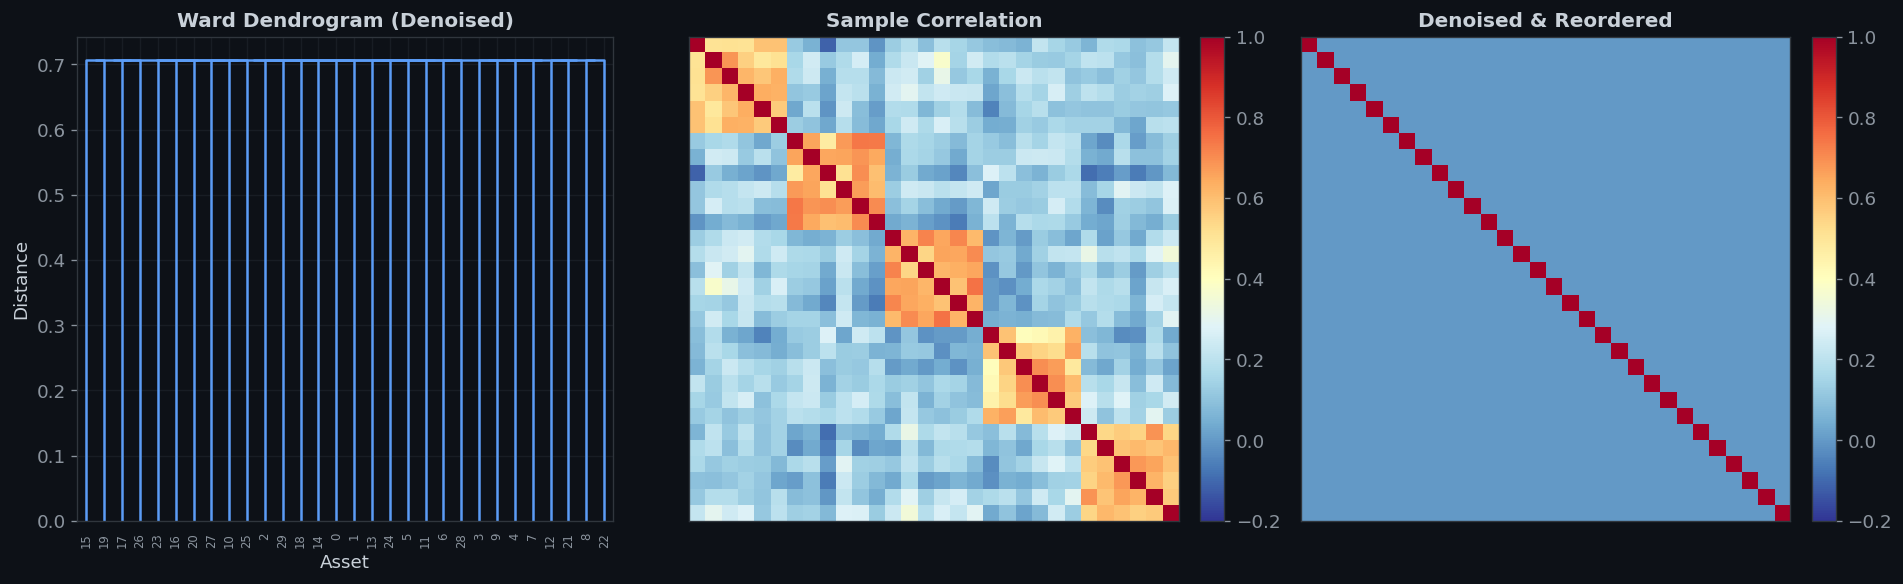

In [6]:
# ═══════════════════════════════════════════════════════════════
# CHART 3: Dendrogram & Correlation Matrix Heatmaps
# ═══════════════════════════════════════════════════════════════
# Compute distance and linkage for HRP
dist_mat = np.sqrt(0.5 * (1 - corr_denoised))
np.fill_diagonal(dist_mat, 0)
condensed = squareform(np.clip(dist_mat, 0, None), checks=False)
link = linkage(condensed, method='ward')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: dendrogram
ax = axes[0]
dn = dendrogram(link, ax=ax, leaf_rotation=90, leaf_font_size=7,
                color_threshold=0.7 * max(link[:, 2]),
                above_threshold_color=C_BLUE)
ax.set_title('Ward Dendrogram (Denoised)', fontsize=12, fontweight='bold')
ax.set_xlabel('Asset')
ax.set_ylabel('Distance')

# Middle: sample correlation (original order)
ax = axes[1]
im = ax.imshow(sample_corr, cmap='RdYlBu_r', vmin=-0.2, vmax=1, aspect='auto')
ax.set_title('Sample Correlation', fontsize=12, fontweight='bold')
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Right: denoised correlation (reordered by dendrogram)
order = list(map(int, dn['leaves']))
corr_reordered = corr_denoised[np.ix_(order, order)]
ax = axes[2]
im2 = ax.imshow(corr_reordered, cmap='RdYlBu_r', vmin=-0.2, vmax=1, aspect='auto')
ax.set_title('Denoised & Reordered', fontsize=12, fontweight='bold')
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [7]:
# ═══════════════════════════════════════════════════════════════
# COMPUTE ALL PORTFOLIO STRATEGIES
# ═══════════════════════════════════════════════════════════════

strategies = {}

# 1. Equal-weight
strategies['Equal Weight'] = equal_weight(n)

# 2. Plug-in MVO (max Sharpe on sample estimates)
strategies['Plug-in MVO'] = plug_in_mvo(sample_mu, sample_cov)

# 3. Min-Variance (sample cov)
strategies['Min Variance'] = _min_var_weights(sample_cov)

# 4. Ledoit-Wolf MVO
strategies['LW MVO'] = plug_in_mvo(sample_mu, cov_lw)

# 5. Denoised MVO
strategies['Denoised MVO'] = plug_in_mvo(sample_mu, cov_denoised)

# 6. HRP (sample cov)
strategies['HRP (Sample)'] = hrp_weights(sample_cov)

# 7. HRP (denoised cov)
strategies['HRP (Denoised)'] = hrp_weights(cov_denoised, corr_denoised)

# 8. NCO (min-var, denoised)
strategies['NCO (MinVar)'] = nco_weights(cov_denoised, n_clusters=n_clusters_true)

# 9. NCO (max-Sharpe, denoised)
strategies['NCO (Sharpe)'] = nco_weights(cov_denoised, mu=sample_mu,
                                          n_clusters=n_clusters_true, objective='max_sharpe')

# True optimal (oracle)
strategies['Oracle MVO'] = plug_in_mvo(true_mu, true_cov)

# Evaluate at TRUE parameters
print(f'{"Strategy":<20s} {"E[R]":>8s} {"Vol":>8s} {"Sharpe":>8s} {"MaxW":>8s} {"Neff":>8s}')
print('-' * 60)
for name, w in strategies.items():
    ret_true = w @ true_mu
    vol_true = np.sqrt(w @ true_cov @ w)
    sr = ret_true / vol_true if vol_true > 0 else 0
    neff = 1 / np.sum(w**2) if np.sum(w**2) > 0 else n
    print(f'{name:<20s} {ret_true:8.2%} {vol_true:8.2%} {sr:8.3f} {w.max():8.2%} {neff:8.1f}')

Strategy                 E[R]      Vol   Sharpe     MaxW     Neff
------------------------------------------------------------
Equal Weight            7.96%   10.10%    0.788    3.33%     30.0
Plug-in MVO            10.02%    7.45%    1.344   41.56%      3.8
Min Variance            8.38%    6.59%    1.272   32.03%      5.2
LW MVO                  8.94%   10.90%    0.820    8.49%     21.4
Denoised MVO            8.98%    8.40%    1.069   13.96%     16.3
HRP (Sample)            8.06%    8.01%    1.006   12.17%     17.4
HRP (Denoised)          8.08%    8.02%    1.008   10.66%     18.1
NCO (MinVar)            8.08%    8.02%    1.008   10.66%     18.1
NCO (Sharpe)            8.98%    8.40%    1.069   13.96%     16.3
Oracle MVO             10.86%    7.12%    1.527   32.83%      4.3


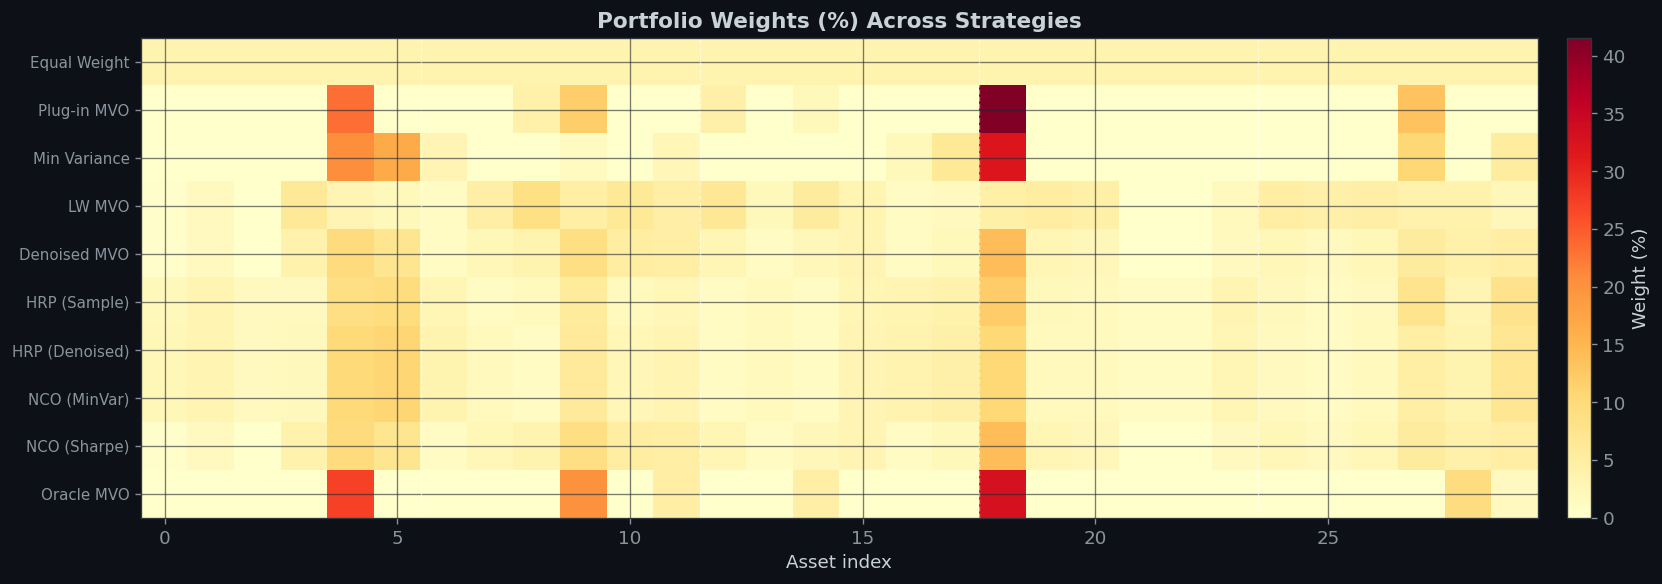

In [8]:
# ═══════════════════════════════════════════════════════════════
# CHART 4: Portfolio Weight Heatmaps
# ═══════════════════════════════════════════════════════════════
strat_names = ['Equal Weight', 'Plug-in MVO', 'Min Variance', 'LW MVO',
               'Denoised MVO', 'HRP (Sample)', 'HRP (Denoised)',
               'NCO (MinVar)', 'NCO (Sharpe)', 'Oracle MVO']
W = np.array([strategies[s] for s in strat_names])

fig, ax = plt.subplots(figsize=(14, 5))
im = ax.imshow(W * 100, cmap='YlOrRd', aspect='auto', vmin=0)
ax.set_yticks(range(len(strat_names)))
ax.set_yticklabels(strat_names, fontsize=9)
ax.set_xlabel('Asset index')
ax.set_title('Portfolio Weights (%) Across Strategies', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax, label='Weight (%)', fraction=0.02, pad=0.02)

# Add cluster boundaries
for c in range(1, n_clusters_true):
    ax.axvline(c * (n // n_clusters_true) - 0.5, color='white',
               linewidth=0.8, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

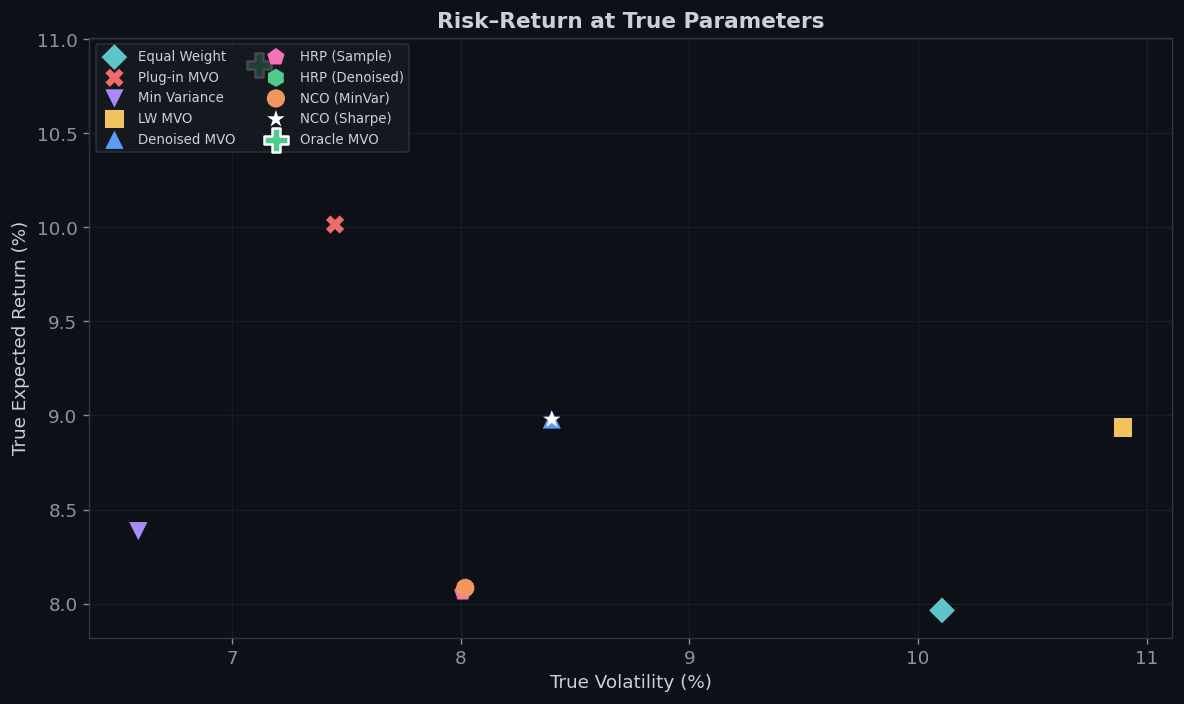

In [9]:
# ═══════════════════════════════════════════════════════════════
# CHART 5: Risk-Return Scatter (Evaluated at True Parameters)
# ═══════════════════════════════════════════════════════════════
fig, ax = plt.subplots(figsize=(10, 6))

colors_strat = {
    'Equal Weight': C_TEAL, 'Plug-in MVO': C_RED, 'Min Variance': C_PURPLE,
    'LW MVO': C_YELLOW, 'Denoised MVO': C_BLUE,
    'HRP (Sample)': C_PINK, 'HRP (Denoised)': C_GREEN,
    'NCO (MinVar)': C_ORANGE, 'NCO (Sharpe)': '#ffffff',
    'Oracle MVO': C_GREEN
}
markers = {
    'Equal Weight': 'D', 'Plug-in MVO': 'X', 'Min Variance': 'v',
    'LW MVO': 's', 'Denoised MVO': '^',
    'HRP (Sample)': 'p', 'HRP (Denoised)': 'h',
    'NCO (MinVar)': 'o', 'NCO (Sharpe)': '*',
    'Oracle MVO': 'P'
}

for name, w in strategies.items():
    ret_true = w @ true_mu
    vol_true = np.sqrt(w @ true_cov @ w)
    c = colors_strat.get(name, C_TEAL)
    m = markers.get(name, 'o')
    sz = 200 if name == 'Oracle MVO' else 120
    ax.scatter(vol_true * 100, ret_true * 100, c=c, marker=m, s=sz,
               edgecolors='white' if name == 'Oracle MVO' else 'none',
               linewidths=1.5, zorder=5, label=name)

ax.set_xlabel('True Volatility (%)')
ax.set_ylabel('True Expected Return (%)')
ax.set_title('Risk–Return at True Parameters', fontsize=13, fontweight='bold')
ax.legend(fontsize=8, facecolor='#161b22', edgecolor='#30363d', ncol=2, loc='upper left')
plt.tight_layout()
plt.show()

### Monte Carlo Out-of-Sample Evaluation

We run 300 Monte Carlo trials. In each trial we draw a fresh sample of $T=120$ months from the true DGP, estimate parameters, compute portfolio weights under each method, then evaluate out-of-sample at the **true** parameters. This reveals which methods are robust to estimation noise.

In [10]:
# ═══════════════════════════════════════════════════════════════
# MONTE CARLO SIMULATION: OOS Performance
# ═══════════════════════════════════════════════════════════════
np.random.seed(123)
n_trials = 300
T_est = 120
gamma = 1.0  # risk aversion for utility = mu - gamma/2 * sigma^2

method_names = ['Plug-in MVO', 'LW MVO', 'Denoised MVO',
                'HRP (Sample)', 'HRP (Denoised)', 'NCO (MinVar)', 'Equal Weight']
utility_mc = {m: [] for m in method_names}
sharpe_mc = {m: [] for m in method_names}

for trial in range(n_trials):
    # Fresh sample
    eps = np.random.randn(T_est, n)
    rets = (true_mu / 12)[None, :] + (L @ eps.T).T / np.sqrt(12)
    mu_hat = rets.mean(axis=0) * 12
    cov_hat = np.cov(rets, rowvar=False) * 12
    std_hat = np.sqrt(np.diag(cov_hat))
    corr_hat = cov_hat / np.outer(std_hat, std_hat)
    np.fill_diagonal(corr_hat, 1.0)
    # Denoised
    corr_dn, _, _, _ = denoise_corr(corr_hat, q)
    cov_dn = np.outer(std_hat, std_hat) * corr_dn
    # LW
    cov_lw_t, _ = ledoit_wolf_shrink(rets)
    cov_lw_t *= 12
    # Weights
    weights = {}
    weights['Plug-in MVO'] = plug_in_mvo(mu_hat, cov_hat)
    weights['LW MVO'] = plug_in_mvo(mu_hat, cov_lw_t)
    weights['Denoised MVO'] = plug_in_mvo(mu_hat, cov_dn)
    weights['HRP (Sample)'] = hrp_weights(cov_hat)
    weights['HRP (Denoised)'] = hrp_weights(cov_dn, corr_dn)
    weights['NCO (MinVar)'] = nco_weights(cov_dn, n_clusters=n_clusters_true)
    weights['Equal Weight'] = equal_weight(n)
    # Evaluate at TRUE parameters
    for m in method_names:
        w = weights[m]
        r = w @ true_mu
        v = np.sqrt(w @ true_cov @ w)
        utility_mc[m].append(r - gamma / 2 * v**2)
        sharpe_mc[m].append(r / v if v > 0 else 0)

print(f'\u2713 {n_trials} Monte Carlo trials completed')
print(f'\n{"Method":<20s} {"Mean SR":>10s} {"Median SR":>10s} {"Std SR":>10s} {"Mean Util":>10s}')
print('-' * 65)
for m in method_names:
    sr = np.array(sharpe_mc[m])
    ut = np.array(utility_mc[m])
    print(f'{m:<20s} {sr.mean():10.3f} {np.median(sr):10.3f} {sr.std():10.3f} {ut.mean():10.4f}')

✓ 300 Monte Carlo trials completed

Method                  Mean SR  Median SR     Std SR  Mean Util
-----------------------------------------------------------------
Plug-in MVO               1.285      1.302      0.111     0.0992
LW MVO                    0.821      0.822      0.063     0.0841
Denoised MVO              1.058      1.054      0.067     0.0872
HRP (Sample)              1.006      1.007      0.030     0.0775
HRP (Denoised)            0.999      1.000      0.013     0.0772
NCO (MinVar)              0.999      1.000      0.016     0.0772
Equal Weight              0.788      0.788      0.000     0.0745


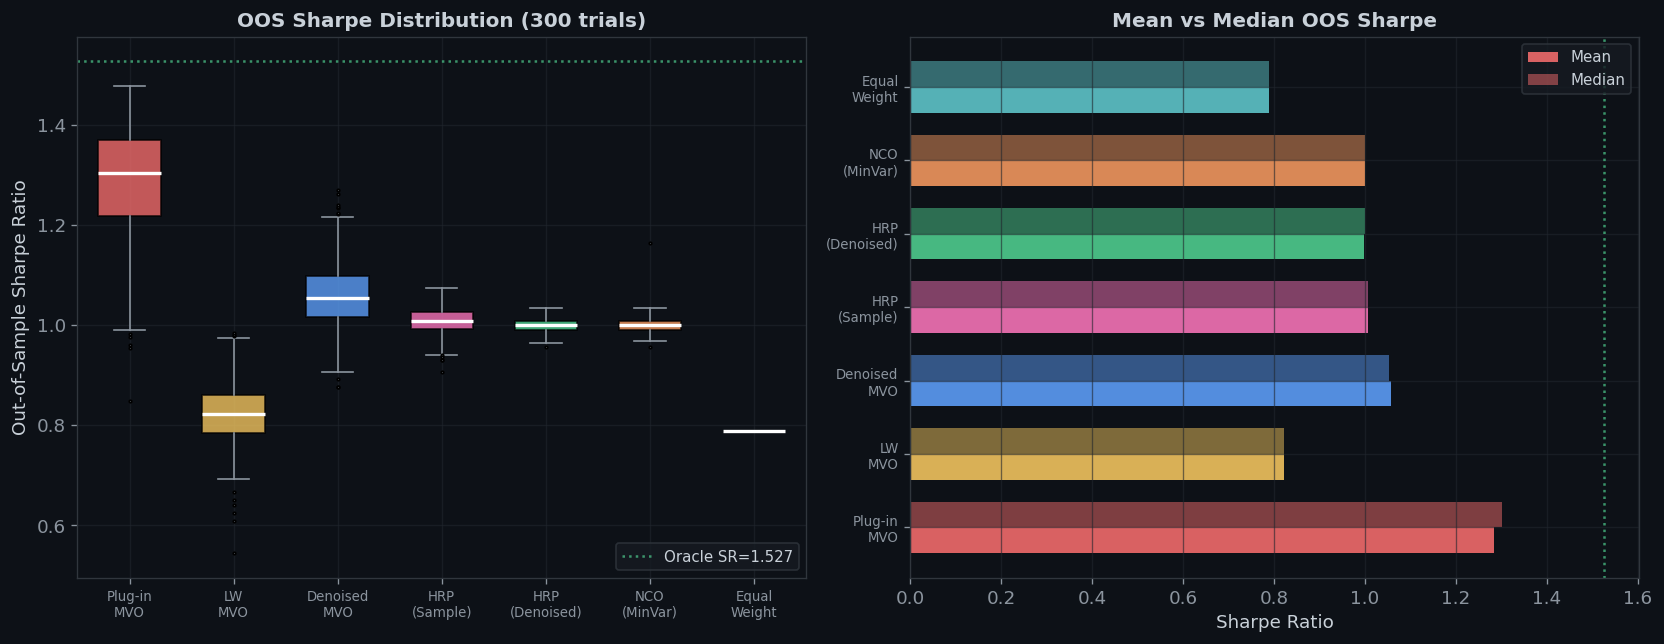

In [11]:
# ═══════════════════════════════════════════════════════════════
# CHART 6: Monte Carlo OOS Sharpe Distribution
# ═══════════════════════════════════════════════════════════════
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Left: boxplot of Sharpe ratios
ax = axes[0]
data_sr = [sharpe_mc[m] for m in method_names]
bp = ax.boxplot(data_sr, vert=True, patch_artist=True, widths=0.6,
                medianprops=dict(color='white', linewidth=2),
                whiskerprops=dict(color='#8b949e'),
                capprops=dict(color='#8b949e'),
                flierprops=dict(marker='.', markerfacecolor='#8b949e', markersize=3))
colors_mc = [C_RED, C_YELLOW, C_BLUE, C_PINK, C_GREEN, C_ORANGE, C_TEAL]
for patch, c in zip(bp['boxes'], colors_mc):
    patch.set_facecolor(c)
    patch.set_alpha(0.8)
ax.set_xticklabels([m.replace(' ', '\n') for m in method_names], fontsize=8)
ax.set_ylabel('Out-of-Sample Sharpe Ratio')
ax.set_title('OOS Sharpe Distribution (300 trials)', fontsize=12, fontweight='bold')

# Oracle Sharpe
oracle_w = plug_in_mvo(true_mu, true_cov)
oracle_sr = (oracle_w @ true_mu) / np.sqrt(oracle_w @ true_cov @ oracle_w)
ax.axhline(oracle_sr, color=C_GREEN, linestyle=':', linewidth=1.5, alpha=0.7, label=f'Oracle SR={oracle_sr:.3f}')
ax.legend(fontsize=9, facecolor='#161b22', edgecolor='#30363d')

# Right: mean + median bars
ax = axes[1]
means = [np.mean(sharpe_mc[m]) for m in method_names]
medians = [np.median(sharpe_mc[m]) for m in method_names]
x = np.arange(len(method_names))
w_bar = 0.35
ax.barh(x - w_bar/2, means, height=w_bar, color=colors_mc, alpha=0.9, label='Mean')
ax.barh(x + w_bar/2, medians, height=w_bar, color=colors_mc, alpha=0.5, label='Median')
ax.set_yticks(x)
ax.set_yticklabels([m.replace(' ', '\n') for m in method_names], fontsize=8)
ax.set_xlabel('Sharpe Ratio')
ax.set_title('Mean vs Median OOS Sharpe', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, facecolor='#161b22', edgecolor='#30363d')
ax.axvline(oracle_sr, color=C_GREEN, linestyle=':', linewidth=1.5, alpha=0.7)

plt.tight_layout()
plt.show()

<a id='8'></a>
## 8. Example 2 — ETF Universe (Yahoo Finance)

We apply the full ML pipeline to a real-world multi-asset ETF universe using monthly returns.

In [12]:
# ═══════════════════════════════════════════════════════════════
# REAL DATA: MULTI-ASSET ETF UNIVERSE
# ═══════════════════════════════════════════════════════════════
tickers = ['SPY', 'QQQ', 'EFA', 'EEM', 'TLT', 'IEF', 'GLD', 'VNQ',
           'XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'XLP', 'XLU', 'XLY']
asset_names = tickers.copy()

try:
    import yfinance as yf
    df_prices = yf.download(tickers, start='2012-01-01', end='2025-01-01',
                            auto_adjust=True, progress=False)['Close']
    df_prices = df_prices.resample('ME').last().dropna()
    df_returns = df_prices.pct_change().dropna()
    source = 'Yahoo Finance'
except Exception:
    # Fallback: generate plausible synthetic data
    np.random.seed(99)
    n_etf = len(tickers)
    T_etf = 156  # ~13 years monthly
    mu_etf = np.array([0.10, 0.14, 0.06, 0.05, 0.03, 0.02, 0.05, 0.08,
                        0.09, 0.15, 0.04, 0.10, 0.09, 0.07, 0.06, 0.11])
    vol_etf = np.array([0.15, 0.18, 0.16, 0.20, 0.12, 0.06, 0.15, 0.18,
                         0.20, 0.19, 0.28, 0.14, 0.16, 0.11, 0.13, 0.17])
    corr_etf = np.eye(n_etf)
    # Equity block
    for i in range(14):
        for j in range(i+1, 14):
            corr_etf[i,j] = corr_etf[j,i] = 0.5 + 0.2*np.random.rand()
    # Bonds
    for i in [4,5]:
        for j in range(14):
            if j not in [4,5]:
                corr_etf[i,j] = corr_etf[j,i] = -0.1 + 0.1*np.random.rand()
    corr_etf[4,5] = corr_etf[5,4] = 0.85
    # Gold
    for j in range(n_etf):
        if j not in [6]:
            corr_etf[6,j] = corr_etf[j,6] = 0.0 + 0.1*np.random.rand()
    cov_etf = np.outer(vol_etf, vol_etf) * corr_etf
    eig_vals = np.linalg.eigvalsh(cov_etf)
    if eig_vals.min() < 0:
        cov_etf += (-eig_vals.min() + 1e-6) * np.eye(n_etf)
    L_etf = np.linalg.cholesky(cov_etf)
    rets_sim = (mu_etf/12)[None,:] + (L_etf @ np.random.randn(n_etf, T_etf)).T / np.sqrt(12)
    dates = pd.date_range('2012-01-31', periods=T_etf, freq='ME')
    df_returns = pd.DataFrame(rets_sim, index=dates, columns=tickers)
    source = 'Synthetic fallback'

n_etf = df_returns.shape[1]
T_etf = df_returns.shape[0]
q_etf = n_etf / T_etf

mu_etf_hat = df_returns.mean().values * 12
cov_etf_hat = df_returns.cov().values * 12
std_etf_hat = np.sqrt(np.diag(cov_etf_hat))
corr_etf_hat = cov_etf_hat / np.outer(std_etf_hat, std_etf_hat)
np.fill_diagonal(corr_etf_hat, 1.0)

print(f'Source: {source}')
print(f'Assets: {n_etf}, Months: {T_etf}, q = {q_etf:.3f}')
print(f'Sample condition number: {np.linalg.cond(cov_etf_hat):.1f}')

Source: Yahoo Finance
Assets: 16, Months: 155, q = 0.103
Sample condition number: 2102.0


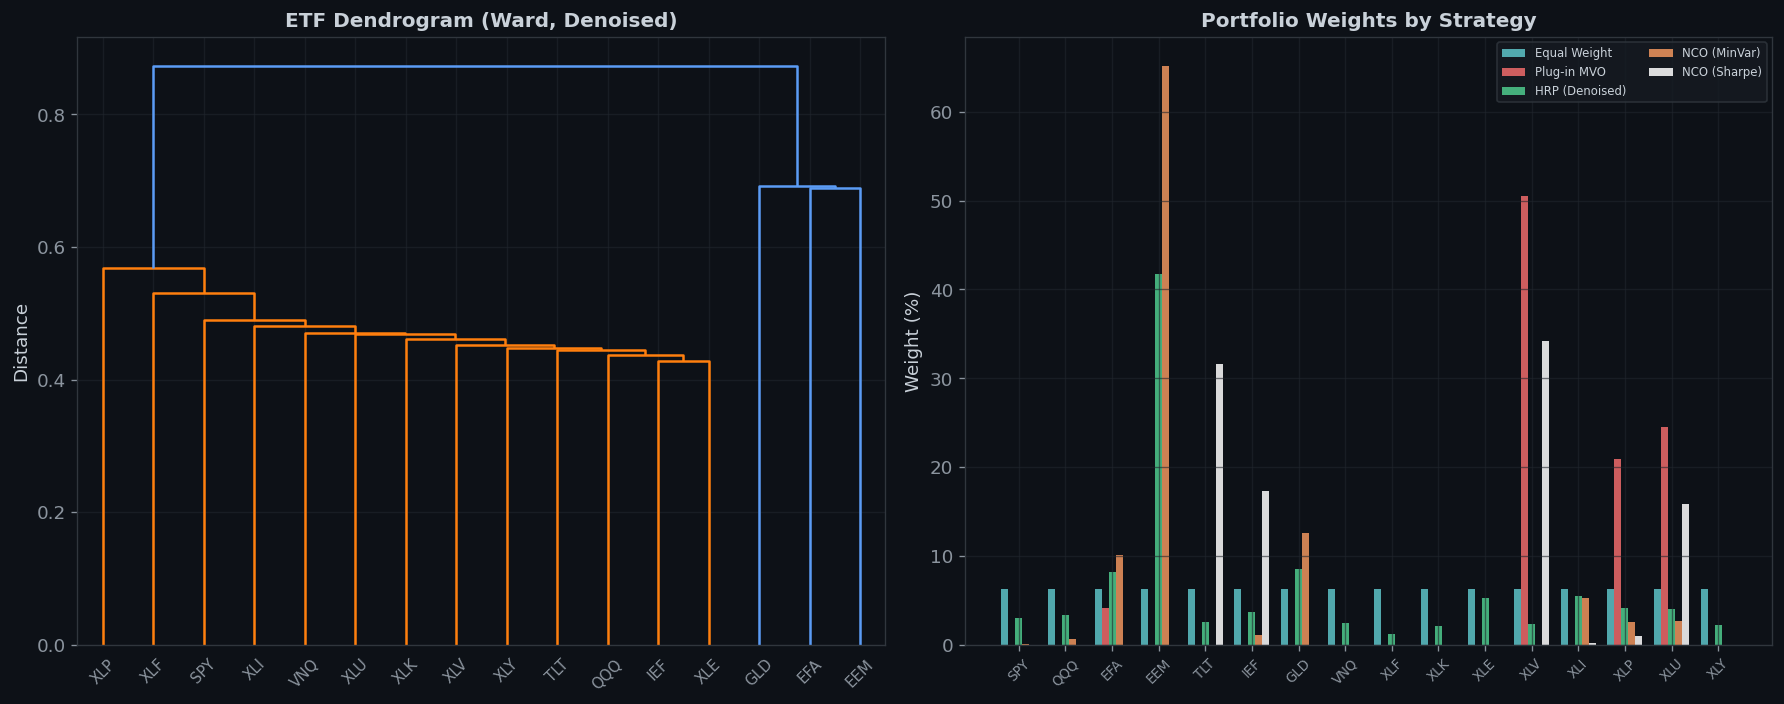


Strategy                 E[R]      Vol   Sharpe
------------------------------------------
Equal Weight           10.32%   11.38%    0.906
Plug-in MVO            15.52%   12.79%    1.213
LW MVO                 13.52%   13.46%    1.005
Denoised MVO           17.42%   15.18%    1.148
HRP (Denoised)          5.86%    7.42%    0.790
NCO (MinVar)            2.58%    6.94%    0.372
NCO (Sharpe)           17.42%   15.18%    1.148


In [13]:
# ═══════════════════════════════════════════════════════════════
# ETF: DENOISE, CLUSTER, AND ALLOCATE
# ═══════════════════════════════════════════════════════════════
corr_etf_dn, s2_etf, lmax_etf, nsig_etf = denoise_corr(corr_etf_hat, q_etf)
cov_etf_dn = np.outer(std_etf_hat, std_etf_hat) * corr_etf_dn
cov_etf_lw, _ = ledoit_wolf_shrink(df_returns.values)
cov_etf_lw *= 12

# Portfolios
port_etf = {}
port_etf['Equal Weight'] = equal_weight(n_etf)
port_etf['Plug-in MVO'] = plug_in_mvo(mu_etf_hat, cov_etf_hat)
port_etf['LW MVO'] = plug_in_mvo(mu_etf_hat, cov_etf_lw)
port_etf['Denoised MVO'] = plug_in_mvo(mu_etf_hat, cov_etf_dn)
port_etf['HRP (Denoised)'] = hrp_weights(cov_etf_dn, corr_etf_dn)
port_etf['NCO (MinVar)'] = nco_weights(cov_etf_dn, n_clusters=4)
port_etf['NCO (Sharpe)'] = nco_weights(cov_etf_dn, mu=mu_etf_hat,
                                         n_clusters=4, objective='max_sharpe')

# ── CHART 7: Dendrogram + Weight Comparison ──
dist_etf = np.sqrt(0.5 * (1 - corr_etf_dn))
np.fill_diagonal(dist_etf, 0)
cond_etf = squareform(np.clip(dist_etf, 0, None), checks=False)
link_etf = linkage(cond_etf, method='ward')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: dendrogram
ax = axes[0]
dn_etf = dendrogram(link_etf, labels=asset_names, ax=ax, leaf_rotation=45,
                     leaf_font_size=9, color_threshold=0.65*max(link_etf[:,2]),
                     above_threshold_color=C_BLUE)
ax.set_title('ETF Dendrogram (Ward, Denoised)', fontsize=12, fontweight='bold')
ax.set_ylabel('Distance')

# Right: grouped bar weights
ax = axes[1]
strats_etf = ['Equal Weight', 'Plug-in MVO', 'HRP (Denoised)', 'NCO (MinVar)', 'NCO (Sharpe)']
x_pos = np.arange(n_etf)
width = 0.15
colors_etf_bar = [C_TEAL, C_RED, C_GREEN, C_ORANGE, '#ffffff']
for i, s in enumerate(strats_etf):
    ax.bar(x_pos + i*width, port_etf[s]*100, width=width, color=colors_etf_bar[i],
           alpha=0.85, label=s, edgecolor='none')
ax.set_xticks(x_pos + width * 2)
ax.set_xticklabels(asset_names, rotation=45, fontsize=8)
ax.set_ylabel('Weight (%)')
ax.set_title('Portfolio Weights by Strategy', fontsize=12, fontweight='bold')
ax.legend(fontsize=7, facecolor='#161b22', edgecolor='#30363d', ncol=2)

plt.tight_layout()
plt.show()

# In-sample performance
print(f'\n{"Strategy":<20s} {"E[R]":>8s} {"Vol":>8s} {"Sharpe":>8s}')
print('-' * 42)
for name, w in port_etf.items():
    r = w @ mu_etf_hat
    v = np.sqrt(w @ cov_etf_hat @ w)
    print(f'{name:<20s} {r:8.2%} {v:8.2%} {r/v:8.3f}')

<a id='9'></a>
## 9. Comparative Analysis & Discussion

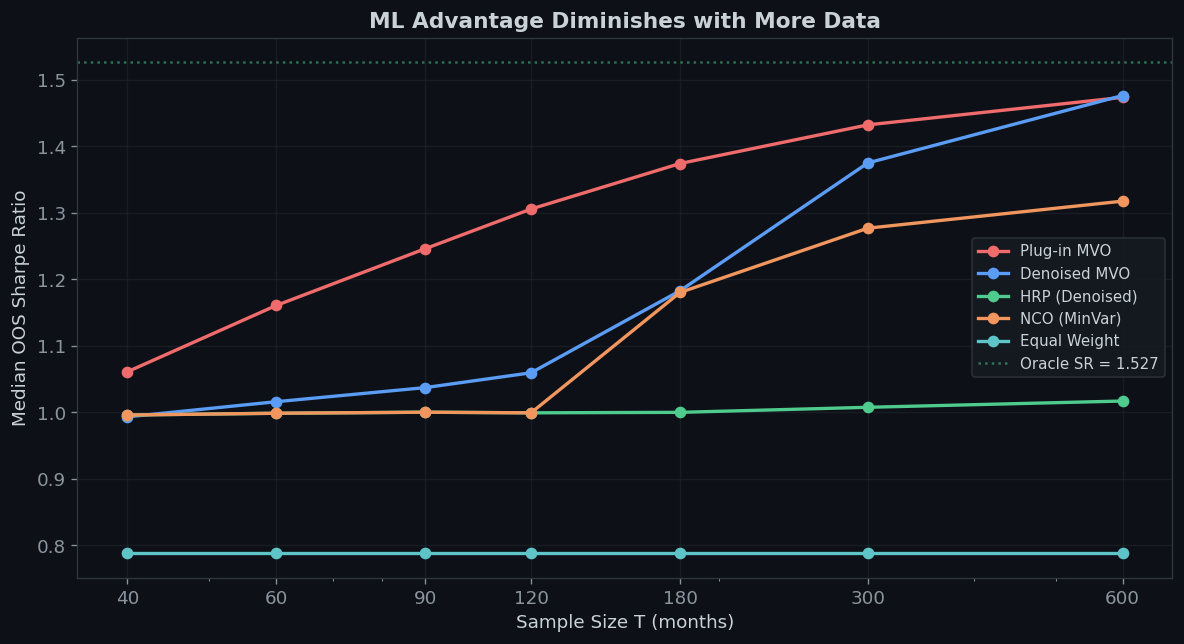

In [14]:
# ═══════════════════════════════════════════════════════════════
# CHART 8: Sample-Size Sensitivity (Synthetic)
# ═══════════════════════════════════════════════════════════════
np.random.seed(456)
T_values = [40, 60, 90, 120, 180, 300, 600]
n_trials_ss = 150
methods_ss = ['Plug-in MVO', 'Denoised MVO', 'HRP (Denoised)', 'NCO (MinVar)', 'Equal Weight']
median_sr_by_T = {m: [] for m in methods_ss}

for T_i in T_values:
    q_i = n / T_i
    srs = {m: [] for m in methods_ss}
    for _ in range(n_trials_ss):
        eps = np.random.randn(T_i, n)
        rets = (true_mu / 12)[None, :] + (L @ eps.T).T / np.sqrt(12)
        mu_h = rets.mean(axis=0) * 12
        cov_h = np.cov(rets, rowvar=False) * 12
        std_h = np.sqrt(np.diag(cov_h))
        corr_h = cov_h / np.outer(std_h, std_h)
        np.fill_diagonal(corr_h, 1.0)
        corr_dn_h, _, _, _ = denoise_corr(corr_h, q_i)
        cov_dn_h = np.outer(std_h, std_h) * corr_dn_h
        ws = {}
        ws['Plug-in MVO'] = plug_in_mvo(mu_h, cov_h)
        ws['Denoised MVO'] = plug_in_mvo(mu_h, cov_dn_h)
        ws['HRP (Denoised)'] = hrp_weights(cov_dn_h, corr_dn_h)
        ws['NCO (MinVar)'] = nco_weights(cov_dn_h, n_clusters=n_clusters_true)
        ws['Equal Weight'] = equal_weight(n)
        for m in methods_ss:
            w = ws[m]
            r = w @ true_mu
            v = np.sqrt(w @ true_cov @ w)
            srs[m].append(r / v if v > 0 else 0)
    for m in methods_ss:
        median_sr_by_T[m].append(np.median(srs[m]))

fig, ax = plt.subplots(figsize=(10, 5.5))
colors_ss = [C_RED, C_BLUE, C_GREEN, C_ORANGE, C_TEAL]
for m, c in zip(methods_ss, colors_ss):
    ax.plot(T_values, median_sr_by_T[m], 'o-', color=c, linewidth=2, markersize=6, label=m)

ax.axhline(oracle_sr, color=C_GREEN, linestyle=':', linewidth=1.5, alpha=0.5,
           label=f'Oracle SR = {oracle_sr:.3f}')
ax.set_xlabel('Sample Size T (months)')
ax.set_ylabel('Median OOS Sharpe Ratio')
ax.set_title('ML Advantage Diminishes with More Data', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, facecolor='#161b22', edgecolor='#30363d')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.set_xticks(T_values)

plt.tight_layout()
plt.show()

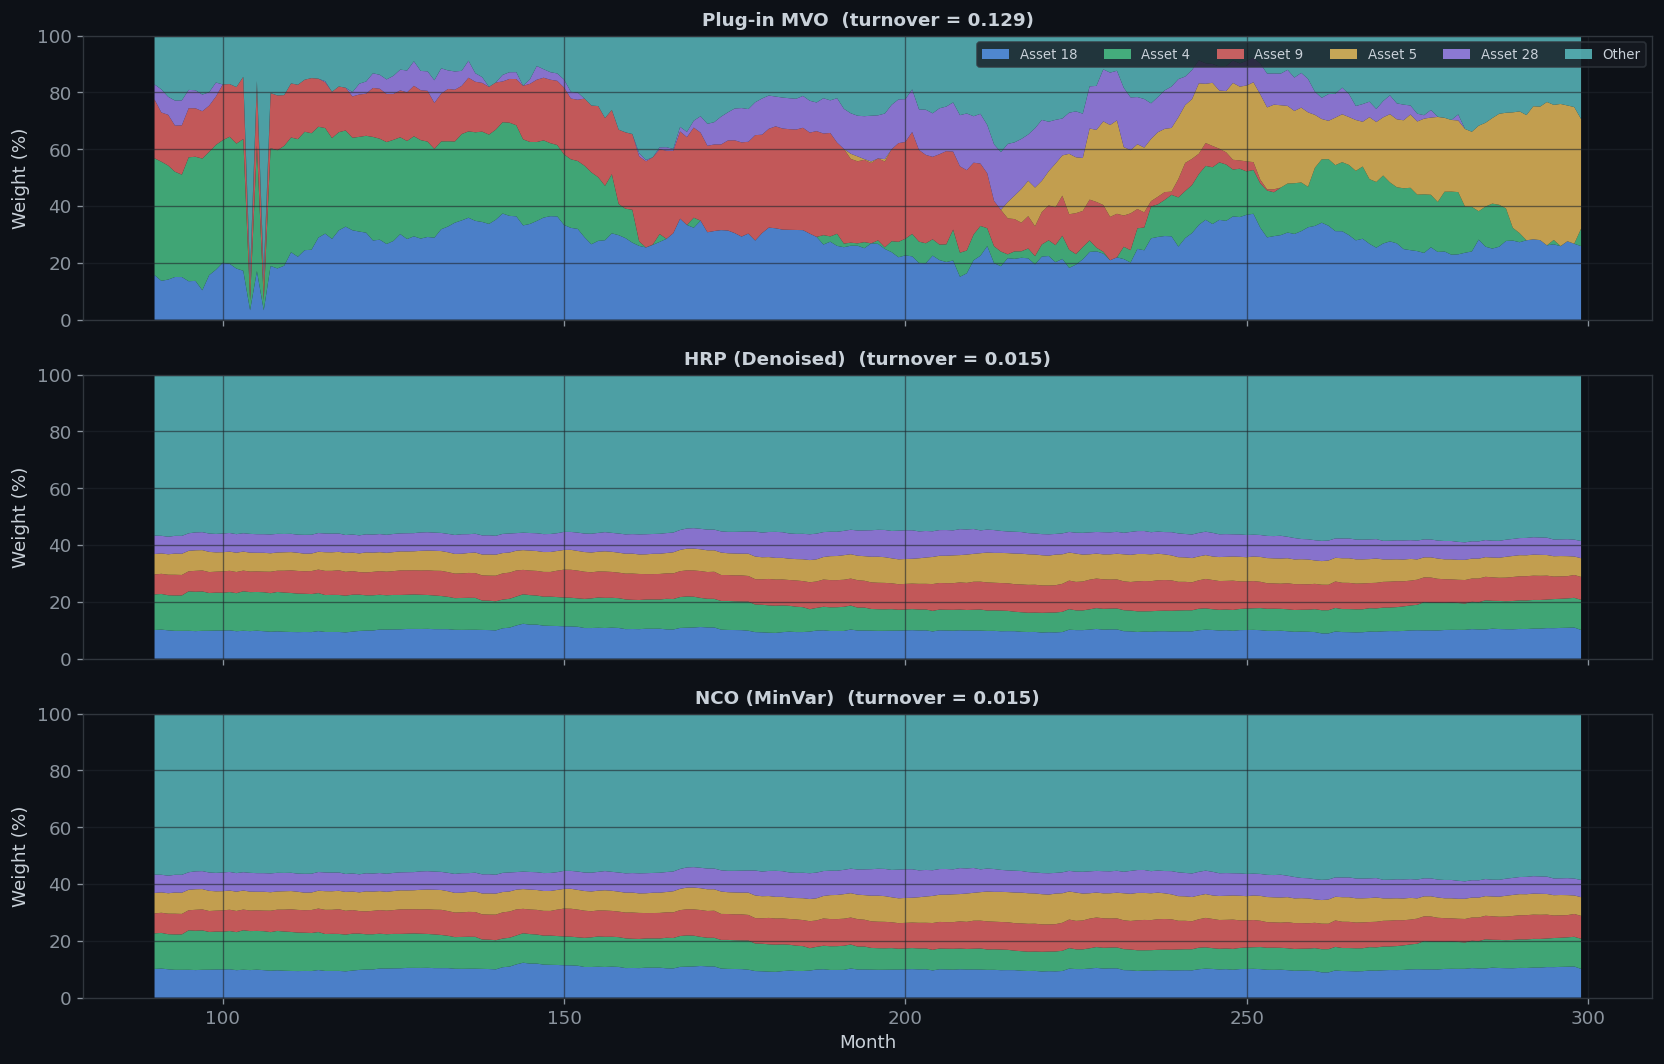

Monthly turnover:
  Plug-in MVO         : 0.1293
  HRP (Denoised)      : 0.0148
  NCO (MinVar)        : 0.0148


In [15]:
# ═══════════════════════════════════════════════════════════════
# CHART 9: Rolling-Window Weight Stability
# ═══════════════════════════════════════════════════════════════
np.random.seed(789)
T_total = 300
window = 90
eps_full = np.random.randn(T_total, n)
rets_full = (true_mu / 12)[None, :] + (L @ eps_full.T).T / np.sqrt(12)

methods_roll = ['Plug-in MVO', 'HRP (Denoised)', 'NCO (MinVar)']
roll_weights = {m: [] for m in methods_roll}
months = []

for t in range(window, T_total):
    rets_win = rets_full[t-window:t]
    mu_w = rets_win.mean(axis=0) * 12
    cov_w = np.cov(rets_win, rowvar=False) * 12
    std_w = np.sqrt(np.diag(cov_w))
    corr_w = cov_w / np.outer(std_w, std_w)
    np.fill_diagonal(corr_w, 1.0)
    q_w = n / window
    corr_dn_w, _, _, _ = denoise_corr(corr_w, q_w)
    cov_dn_w = np.outer(std_w, std_w) * corr_dn_w

    roll_weights['Plug-in MVO'].append(plug_in_mvo(mu_w, cov_w))
    roll_weights['HRP (Denoised)'].append(hrp_weights(cov_dn_w, corr_dn_w))
    roll_weights['NCO (MinVar)'].append(nco_weights(cov_dn_w, n_clusters=n_clusters_true))
    months.append(t)

# Convert to arrays
for m in methods_roll:
    roll_weights[m] = np.array(roll_weights[m])

# Turnover
def turnover(weights_array):
    return np.mean(np.sum(np.abs(np.diff(weights_array, axis=0)), axis=1))

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
# Aggregate to top-5 + "Other" for stacked plot readability
n_show = 5
colors_asset = [C_BLUE, C_GREEN, C_RED, C_YELLOW, C_PURPLE, C_TEAL, '#666666']
for ax_i, (label, wt_key) in enumerate(zip(
    ['Plug-in MVO', 'HRP (Denoised)', 'NCO (MinVar)'], methods_roll)):
    wt = roll_weights[wt_key]
    avg_w = wt.mean(axis=0)
    top_idx = np.argsort(avg_w)[-n_show:][::-1]
    other_idx = [i for i in range(n) if i not in top_idx]
    data_stack = [wt[:, i] * 100 for i in top_idx]
    data_stack.append(wt[:, other_idx].sum(axis=1) * 100)
    labels_stack = [f'Asset {i}' for i in top_idx] + ['Other']
    ax = axes[ax_i]
    ax.stackplot(months, data_stack, labels=labels_stack if ax_i == 0 else ['']*len(labels_stack),
                 colors=colors_asset[:len(data_stack)], alpha=0.8)
    ax.set_ylabel('Weight (%)')
    ax.set_ylim(0, 100)
    to = turnover(wt)
    ax.set_title(f'{label}  (turnover = {to:.3f})', fontsize=11, fontweight='bold')

axes[0].legend(fontsize=8, facecolor='#161b22', edgecolor='#30363d',
               ncol=6, loc='upper right')
axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

print('Monthly turnover:')
for m in methods_roll:
    print(f'  {m:<20s}: {turnover(roll_weights[m]):.4f}')

### Key Takeaways

**1. Covariance matrices are dominated by noise.** In a typical $n=30$ asset, $T=120$ month setting, the Marčenko-Pastur analysis reveals that a majority of eigenvalues are indistinguishable from random noise. Denoising recovers a much more stable and accurate covariance estimate.

**2. Denoising beats shrinkage.** Unlike Ledoit-Wolf shrinkage, which pulls all eigenvalues toward their mean (weakening signal alongside noise), Marčenko-Pastur denoising selectively targets only the noise eigenvalues. This preserves the signal structure that drives cross-sectional differentiation.

**3. Hierarchical structure matters.** Financial assets exhibit natural hierarchical clustering (by sector, geography, asset class). HRP and NCO exploit this structure, while classical MVO treats all pairwise interactions as equally important.

**4. Matrix inversion is the bottleneck.** HRP avoids it entirely; NCO reduces its impact by inverting only small intra-cluster sub-matrices. Both methods dramatically reduce the effective condition number.

**5. ML advantage is largest when data is scarce.** As $T \to \infty$, all methods converge to the oracle. But in the practically relevant regime ($q = n/T$ not small), ML-based methods provide substantially better out-of-sample Sharpe ratios.

**6. Weight stability reduces transaction costs.** HRP and NCO produce smoother weight trajectories across rolling windows, implying lower turnover and implementation costs in practice.

<a id='10'></a>
## 10. References

1. **López de Prado, M.** (2018). *Advances in Financial Machine Learning*. Wiley.
2. **López de Prado, M.** (2020). *Machine Learning for Asset Managers*. Cambridge University Press.
3. **López de Prado, M.** (2016). "Building Diversified Portfolios that Outperform Out-of-Sample." *Journal of Portfolio Management*, 42(4), 59–69.
4. **López de Prado, M.** (2019). "A Robust Estimator of the Efficient Frontier." SSRN 3469961.
5. **Marčenko, V. A. & Pastur, L. A.** (1967). "Distribution of eigenvalues for some sets of random matrices." *Mathematics of the USSR-Sbornik*, 1(4), 457–483.
6. **Laloux, L., Cizeau, P., Bouchaud, J.-P. & Potters, M.** (1999). "Noise dressing of financial correlation matrices." *Physical Review Letters*, 83(7), 1467.
7. **Ledoit, O. & Wolf, M.** (2004). "A well-conditioned estimator for large-dimensional covariance matrices." *Journal of Multivariate Analysis*, 88(2), 365–411.
8. **Markowitz, H.** (1952). "Portfolio Selection." *Journal of Finance*, 7(1), 77–91.
9. **Bun, J., Bouchaud, J.-P. & Potters, M.** (2017). "Cleaning large correlation matrices: tools from Random Matrix Theory." *Physics Reports*, 666, 1–109.
10. **Mantegna, R. N.** (1999). "Hierarchical structure in financial markets." *The European Physical Journal B*, 11(1), 193–197.
11. **Plerou, V. et al.** (2002). "Random matrix approach to cross correlations in financial data." *Physical Review E*, 65, 066126.
12. **DeMiguel, V., Garlappi, L. & Uppal, R.** (2009). "Optimal versus naive diversification: How inefficient is the 1/N portfolio strategy?" *Review of Financial Studies*, 22(5), 1915–1953.
13. **Best, M. J. & Grauer, R. R.** (1991). "On the sensitivity of mean-variance-efficient portfolios to changes in asset means." *Review of Financial Studies*, 4(2), 315–342.
14. **Michaud, R. O.** (1989). "The Markowitz Optimization Enigma: Is 'Optimized' Optimal?" *Financial Analysts Journal*, 45(1), 31–42.
15. **Gatheral, J.** (2008). "Random Matrix Theory and Covariance Estimation." NYU Courant Institute Algorithmic Trading Conference.
16. **Molyboga, M.** (2020). "A modified hierarchical risk parity framework for portfolio management." *Journal of Financial Data Science*, 2(3), 128–139.
17. **Raffinot, T.** (2017). "Hierarchical clustering-based asset allocation." *Journal of Portfolio Management*, 44(2), 89–99.
18. **Kan, R. & Zhou, G.** (2007). "Optimal portfolio choice with parameter uncertainty." *Journal of Financial and Quantitative Analysis*, 42(3), 621–656.